In [218]:
import time
import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import MinMaxScaler
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder



def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [219]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [254]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [255]:
train_features.cp_time.unique(), train_features.cp_type.unique(),  train_features.cp_dose.unique()



(array([24, 72, 48]),
 array(['trt_cp', 'ctl_vehicle'], dtype=object),
 array(['D1', 'D2'], dtype=object))

In [274]:
ignore_columns = ['sig_id','cp_type']
train_columns = [x for x in train_features.columns if x not in ignore_columns]

train = train_features[train_columns]
test = test_features[train_columns]
target = train_targets_scored.iloc[:,1:].values

In [275]:
train.shape, test.shape, target.shape

((23814, 874), (3982, 874), (23814, 206))

In [276]:
transform = ColumnTransformer([
                            ('o',OneHotEncoder(),[0,1]),
                            ('s',Normalizer(),list(range(3,train.shape[1])))  ## remove
                        ])


train = transform.fit_transform(train)
test = transform.transform(test)



In [277]:
train.shape, test.shape, target.shape

((23814, 876), (3982, 876), (23814, 206))

In [278]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float() 
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature,target

In [290]:
full_dataset = TrainDataset(train, target, noise = False)
print(full_dataset.sizes())

train_size = int(0.98 * len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers = 8)

val_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle = True, num_workers = 8)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

features size =  876
targets size =  206
None
365 batches 
8  batches 


In [291]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [292]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(876)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(876, 1048))
        
        self.batch_norm2 = nn.BatchNorm1d(1048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(1048, 2096))
        
        self.batch_norm3 = nn.BatchNorm1d(2096)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(2096, 2096))
        
        self.batch_norm4 = nn.BatchNorm1d(2096)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(2096, 1048))
        
        self.batch_norm5 = nn.BatchNorm1d(1048)
        #self.dropout5 = nn.Dropout(0.5)
        self.dense5 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))
        
        x = self.batch_norm5(x)
        #x = self.dropout5(x)
        x = (self.dense5(x))
        
        return x
    
    
    
model = Model()
model = model.to(device)
model.apply(weights_init)
print(model)

Model(
  (batch_norm1): BatchNorm1d(876, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=876, out_features=1048, bias=True)
  (batch_norm2): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1048, out_features=2096, bias=True)
  (batch_norm3): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=2096, out_features=2096, bias=True)
  (batch_norm4): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (dense4): Linear(in_features=2096, out_features=1048, bias=True)
  (batch_norm5): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense5): Linear(in_features=1048, out_features=206, b

In [293]:
losses = []
val_losses = []
learning_rates = []
average_deltas = []
val_corr=[]
best_loss = 100

optimizer = optim.Adam(model.parameters(), lr=0.4e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=5, 
                                                 eps=1e-5, 
                                                 verbose=True)
criterion = nn.BCEWithLogitsLoss()

showing no improvements, best loss:  0.015072076581418514


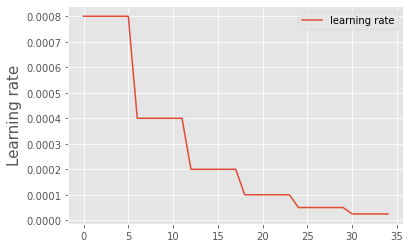

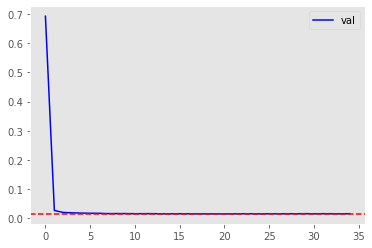

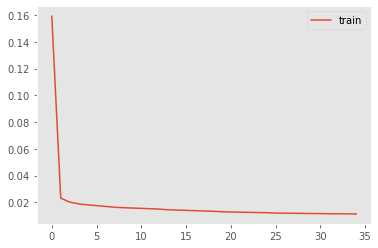

In [294]:
num_epochs=35
for epoch in range(num_epochs):
    
    print ("epoch ", epoch+1, " out of ", num_epochs )
    
    with torch.no_grad():
        model.eval()
        val_losses_temp = []
        for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
            yhat =model(x_val.to(device))  # pred 
            val_loss = criterion(yhat.to(device), y_val.to(device))
            val_losses_temp.append(val_loss.item())  ## metrics 
        val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 

    model.train()
    losses_temp = []
    for batch in tqdm(train_loader, desc = " Training batches : "):
        (x_batch, y_batch) = batch
        loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
        losses_temp.append(loss)
    losses.append(torch.mean(torch.tensor(losses_temp)))
    scheduler.step(1.)   ## lr decay caller 
    learning_rates.append(get_lr(optimizer))
    
    clear_output(wait = True)
    if val_losses[-1] <= best_loss:
        print("Val loss decreased from:", best_loss, " to ", val_losses[-1])
        best_loss = val_losses[-1]
        print("saving model...")
        torch.save(model.state_dict(), "./best_model.pth")

    else: 
        print("showing no improvements, best loss: ", best_loss)

        
    show_lr(learning_rates)
    plt.plot(val_losses,'b', label = "val")
    plt.axhline(min(val_losses), linestyle = "--", c = "r")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(losses, label = "train")
    plt.legend()
    plt.grid()
    plt.show()

In [235]:
(min(val_losses))
#0.013776430860161781
#0.013617528602480888

0.014558246359229088

In [236]:
model = Model()
model = model.to(device)
model.load_state_dict(torch.load("./best_model.pth"))
model.eval()

Model(
  (batch_norm1): BatchNorm1d(877, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=877, out_features=1048, bias=True)
  (batch_norm2): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1048, out_features=2096, bias=True)
  (batch_norm3): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=2096, out_features=2096, bias=True)
  (batch_norm4): BatchNorm1d(2096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (dense4): Linear(in_features=2096, out_features=1048, bias=True)
  (batch_norm5): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense5): Linear(in_features=1048, out_features=206, b

In [237]:
test_dataset = TrainDataset(test, target, noise = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers = 8)

In [238]:
list_of_preds=[]
with torch.no_grad():
    model.eval()
    for x_test, y_test in tqdm(test_loader, desc = "running on test set --"):
        pred =model(x_test.to(device, dtype=torch.float))  # pred 
        pred = pred.cpu()
        pred = pred.sigmoid()
        list_of_preds.append(list(pred[0].numpy()))

In [239]:
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

In [240]:
import csv 
a = list_of_preds  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

In [241]:
final_sub = pd.read_csv('./submission_cp.csv', header = None)
final_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,0.000063,6.705122e-04,0.000614,0.021262,0.012302,0.006936,0.002050,0.001375,0.000059,0.013736,...,0.000247,0.000179,0.003758,0.000124,0.000028,0.000065,0.000076,0.001287,0.000172,0.000454
1,0.000099,7.311772e-04,0.000896,0.000305,0.000230,0.000289,0.002315,0.010397,0.004713,0.001713,...,0.000090,0.000693,0.002981,0.000524,0.008261,0.000052,0.001781,0.000244,0.001830,0.004964
2,0.000007,5.393177e-07,0.000053,0.000237,0.000232,0.000020,0.000017,0.000131,0.000013,0.000272,...,0.000011,0.000098,0.000007,0.000017,0.000220,0.000043,0.000122,0.000012,0.000026,0.000016
3,0.000140,1.932620e-04,0.001936,0.028381,0.008300,0.001254,0.003845,0.001996,0.000466,0.024720,...,0.000310,0.000481,0.000878,0.000566,0.009248,0.000101,0.000629,0.002683,0.000201,0.005421
4,0.001006,8.410985e-04,0.000595,0.008687,0.026452,0.003498,0.002063,0.001280,0.000035,0.007009,...,0.000216,0.000179,0.001152,0.000272,0.000514,0.000232,0.000411,0.001541,0.000084,0.000580


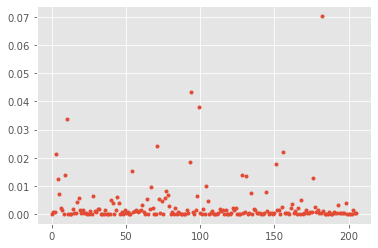

In [242]:
plt.plot(final_sub.values[0], ".")

In [243]:
final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]
good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]
final_sub.to_csv("./submission.csv", index=False)
final_sub



,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000063,6.705122e-04,0.000614,0.021262,0.012302,0.006936,0.002050,0.001375,0.000059,...,0.000247,0.000179,0.003758,0.000124,0.000028,0.000065,0.000076,0.001287,0.000172,0.000454
1,id_001897cda,0.000099,7.311772e-04,0.000896,0.000305,0.000230,0.000289,0.002315,0.010397,0.004713,...,0.000090,0.000693,0.002981,0.000524,0.008261,0.000052,0.001781,0.000244,0.001830,0.004964
2,id_002429b5b,0.000007,5.393177e-07,0.000053,0.000237,0.000232,0.000020,0.000017,0.000131,0.000013,...,0.000011,0.000098,0.000007,0.000017,0.000220,0.000043,0.000122,0.000012,0.000026,0.000016
3,id_00276f245,0.000140,1.932620e-04,0.001936,0.028381,0.008300,0.001254,0.003845,0.001996,0.000466,...,0.000310,0.000481,0.000878,0.000566,0.009248,0.000101,0.000629,0.002683,0.000201,0.005421
4,id_0027f1083,0.001006,8.410985e-04,0.000595,0.008687,0.026452,0.003498,0.002063,0.001280,0.000035,...,0.000216,0.000179,0.001152,0.000272,0.000514,0.000232,0.000411,0.001541,0.000084,0.000580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,0.000032,5.793214e-03,0.000857,0.001966,0.001147,0.002915,0.000668,0.003670,0.000156,...,0.000214,0.034038,0.011600,0.114110,0.002928,0.000435,0.004325,0.000404,0.003698,0.000159
3978,id_ff925dd0d,0.015624,5.756512e-03,0.000047,0.000832,0.038493,0.003013,0.001226,0.002181,0.000064,...,0.000033,0.000045,0.000760,0.000128,0.000537,0.000423,0.001264,0.000564,0.000020,0.000505
3979,id_ffb710450,0.000231,2.774148e-04,0.000301,0.009461,0.023681,0.006123,0.002269,0.005071,0.000037,...,0.000092,0.000179,0.001246,0.000248,0.000230,0.000040,0.000215,0.000602,0.000194,0.001321
3980,id_ffbb869f2,0.000231,2.988102e-04,0.000700,0.032996,0.033669,0.006532,0.006117,0.001411,0.000062,...,0.000167,0.000176,0.001789,0.000206,0.000186,0.000059,0.000146,0.001581,0.000051,0.001193
